# 1. Проект "Телеком"
## 1.1. Задача проекта
<div>Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.</div>

## 1.2. Описание услуг
Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).
<br><br>
Также доступны такие услуги:
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).
<br><br>
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## 1.3. Описание данных
Данные состоят из файлов, полученных из разных источников:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.
<br><br>
<div>Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.</div>
<div><b>Целевым признаком является наличие даты в EndDate</b></div>

# 2. Предобработка данных
## 2.1. Загрузка и предварительное знакомство с данными

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import re
import seaborn as sns
from sklearn.model_selection import cross_val_score

#from sklearn.model_selection import GridSearchCV

#from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve 

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.utils import shuffle

In [2]:
# константы
RANDOM_STATE = 250722
END_DATE = '2020-02-01'
DROP_FIRST = False # пока не боимся даммми-ловушки, если будут плохие результаты, заменим на True чтобы отбросился один из категориальных столбцов
# пока что
# при False метрика 0.8402603392610053
# при True метрика 0.8389663301388817

TEST_SIZE = .20
CRIT_AUR_ROC = .75 # порог приемлемости модели
BEST_AUR_ROC = .88 # лучшее значение AUR_ROC
PATH_1 = r'E:\_личное\DS\final_provider'

In [3]:
# Функция расчета квантилей и допустимого интервала значений
def calc_quantiles(feature):    
    q1, q3 = np.percentile(feature, [25, 75]) 
    iqr = q3 - q1
    lower_bound = max(q1 - (1.5 * iqr), feature.min())
    upper_bound = min(q3 + (1.5 * iqr), feature.max())
    return (q3, q1, lower_bound, upper_bound)

In [4]:
# Функция приведения наименований столбцов в "змеиный" формат
def snake_name(cl_nm):
    i = 0
    spec_char = ['_', ' ', '(', ')', '.']
    for cl in cl_nm:
        nm = cl
        n = 0
        for c in range(len(cl)):
            if cl[c]==cl[c].upper() and (cl[c] not in spec_char) and c>0 and c<(len(cl)-1):
                nm = f'{nm[:(c+n)]}_{nm[(c+n):]}' 
                n += 1
            elif cl[c]==' ':
                nm = f'{nm[:(c+n)]}_{nm[(c+n+1):]}'
            elif cl[c]=='(':
                nm = f'{nm[:(c+n)]}{nm[(c+n+1):]}'
                n -= 1
            elif cl[c]==')':    
                nm = nm[:(c+n)]
        cl_nm[i] = nm.lower()
        i += 1
    return cl_nm        

In [5]:
# загрузка данных
data_contract = pd.read_csv(r'{}\contract.csv'.format(PATH_1))
data_personal = pd.read_csv(r'{}\personal.csv'.format(PATH_1))
data_internet = pd.read_csv(r'{}\internet.csv'.format(PATH_1))
data_phone = pd.read_csv(r'{}\phone.csv'.format(PATH_1))

In [6]:
# первичное знакомство с данными data_contract
print('Информация по файлу contract.csv — информация о договоре:')
data_contract.info()
display(data_contract.head())
display(data_contract.describe())
print('Явные дубли:', data_contract.duplicated().sum())
print('Уникальных customerID:', len(data_contract['customerID'].unique()))
print('Уникальных PaymentMethod:', data_contract['PaymentMethod'].unique())
print('Уникальных Type:', data_contract['Type'].unique())
try:
    data_contract['TotalCharges'] = data_contract['TotalCharges'].astype(np.float64)
except:
    print('Столбец TotalCharges содержит нечисловые значения:')
    TotalCharges = list(data_contract['TotalCharges'])
    tc_out = ''
    for tc in TotalCharges:
        try:
            probe = float(tc)
        except:
            tc_out = tc_out + tc
    print(tc_out)

Информация по файлу contract.csv — информация о договоре:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Явные дубли: 0
Уникальных customerID: 7043
Уникальных PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальных Type: ['Month-to-month' 'One year' 'Two year']
Столбец TotalCharges содержит нечисловые значения:
           


### 2.1.1. Предварительные выводы по contract.csv:
1. Пропуски отсутствуют
2. Явные дубли отсутствуют
3. Наименования столбцов информативные, но для дальнейшей работы их надо привести к правильному формату
4. Время прописано текстом, но преобразовать его в формат времени пока преждевременно, т.к. в столбцах встречаются и другие значения.
5. Для каждого пользователя - одна запись.
6. TotalCharges почему-то прописан текстом. Там есть нечисловые значения - проблелы вместо пропусков данных.
7. Столбцы с Yes/No имеют булевый смысл и их желательно перевести в числовой формат 1/0

In [7]:
# первичное знакомство с данными data_personal — персональные данные клиента;
print('Информация по файлу personal.csv — персональные данные клиента:')
data_personal.info()
display(data_personal.head())
display(data_personal.describe())
print('Уникальных customerID:', len(data_personal['customerID'].unique()))
print('Явные дубли:', data_personal.duplicated().sum())

Информация по файлу personal.csv — персональные данные клиента:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Уникальных customerID: 7043
Явные дубли: 0


### 2.1.2. Предварительные выводы по personal.csv:
1. Пропуски отсутствуют
2. Явные дубли отсутствуют
3. Наименования столбцов информативные, но для дальнейшей работы их надо привести к правильному формату
4. записей столько же сколько и в contract.csv
5. Столбцы с Yes/No имеют булевый смысл и их желательно перевести в числовой формат 1/0

In [8]:
# первичное знакомство с данными internet.csv — информация об интернет-услугах;
print('Информация по файлу internet.csv — информация об интернет-услугах:')
data_internet.info()
display(data_internet.head())
display(data_internet.describe())
print('Уникальных customerID:', len(data_internet['customerID'].unique()))
print('Явные дубли:', data_internet.duplicated().sum())
print('Уникальные InternetService:', data_internet['InternetService'].unique())
print('Уникальные OnlineSecurity:', data_internet['OnlineSecurity'].unique())

Информация по файлу internet.csv — информация об интернет-услугах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Уникальных customerID: 5517
Явные дубли: 0
Уникальные InternetService: ['DSL' 'Fiber optic']
Уникальные OnlineSecurity: ['No' 'Yes']


### 2.1.3. Предварительные выводы по internet.csv:
1. Пропуски отсутствуют
2. Явные дубли отсутствуют
3. Наименования столбцов информативные, но для дальнейшей работы их надо привести к правильному формату
4. Не все пользователи пользуются услугами Интернет
5. Столбцы с Yes/No имеют булевый смысл и их желательно перевести в числовой формат 1/0

In [9]:
# первичное знакомство с данными phone.csv — информация об услугах телефонии;
print('Информация по файлу phone.csv — информация об услугах телефонии:')
data_phone.info()
display(data_phone.head())
display(data_phone.describe())
print('Уникальных customerID:', len(data_phone['customerID'].unique()))
print('Явные дубли:', data_phone.duplicated().sum())

Информация по файлу phone.csv — информация об услугах телефонии:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Уникальных customerID: 6361
Явные дубли: 0


### 2.1.4. Предварительные выводы по phone.csv:
1. Пропуски отсутствуют
2. Явные дубли отсутствуют
3. Наименования столбцов информативные, но для дальнейшей работы их надо привести к правильному формату
4. Не все пользователи пользуются услугами телефонии
5. Столбцы с Yes/No имеют булевый смысл и их желательно перевести в числовой формат 1/0

## 2.2. Предобработка данных
1. Заменить наименования столбцов на корректные
2. Конвертировать время из текста в формат даты
3. Привести булевые данные к числовому формату
4. Разложить категориальные значения по разным столбцам
5. Сформировать целевой признак
6. Объединить все датасеты в один по customerID
7. Финальная обработка

### 2.2.1. Предобработка data_contract

In [10]:
# data_contract
# предыдущие названия столбцов: customerID	BeginDate	EndDate	Type	PaperlessBilling	PaymentMethod	MonthlyCharges	TotalCharges

# Расклад метода платежей и типов контрактов по разным столбцам
payment_method = pd.get_dummies(data_contract['PaymentMethod'], drop_first=DROP_FIRST) 
contract_type = pd.get_dummies(data_contract['Type'], drop_first=DROP_FIRST) 

data_contract = pd.merge(data_contract, payment_method, how ='outer', left_index=True, right_index=True)
data_contract = pd.merge(data_contract, contract_type, how ='outer', left_index=True, right_index=True)

del payment_method
del contract_type

# автоматизируем переименования
column_names = snake_name(list(data_contract.columns))    
data_contract.set_axis(column_names, axis = 'columns',inplace = True) 

# приведение столбцов с Yes/No в числовой формат 1/0
data_contract['paperless_billing'] = np.where(data_contract['paperless_billing']=='Yes', 1, 0)

# c total_charges надо разобраться позднее - после объединения всего датафрейма

# формирование целевого признака
data_contract['client_left'] = np.where(data_contract['end_date']=='No', 0, 1)

# преобразование даты в правильный формат
data_contract['begin_date'] = pd.to_datetime(data_contract['begin_date'], format='%Y.%m.%d')
data_contract['end_date'] = np.where(data_contract['end_date']=='No', END_DATE, data_contract['end_date'])
data_contract['end_date'] = pd.to_datetime(data_contract['end_date'], format='%Y.%m.%d')
data_contract['duration'] = data_contract['end_date'] - data_contract['begin_date']
data_contract['duration'] = data_contract['duration'].astype('timedelta64[D]').astype(np.int64) # длительность контракта в днях

# проверка результатов
display(data_contract.head())
data_contract.info()
display(data_contract.describe())
print('Размер data_contract:', data_contract.shape)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,bank_transfer_automatic,credit_card_automatic,electronic_check,mailed_check,month_-to_-month,one_year,two_year,client_left,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,0,1,0,1,0,0,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.5,0,0,0,1,0,1,0,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,0,0,0,1,1,0,0,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,1,0,0,0,0,1,0,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,0,0,1,0,1,0,0,1,61


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              7043 non-null   object        
 1   begin_date               7043 non-null   datetime64[ns]
 2   end_date                 7043 non-null   datetime64[ns]
 3   type                     7043 non-null   object        
 4   paperless_billing        7043 non-null   int32         
 5   payment_method           7043 non-null   object        
 6   monthly_charges          7043 non-null   float64       
 7   total_charges            7043 non-null   object        
 8   bank_transfer_automatic  7043 non-null   uint8         
 9   credit_card_automatic    7043 non-null   uint8         
 10  electronic_check         7043 non-null   uint8         
 11  mailed_check             7043 non-null   uint8         
 12  month_-to_-month         7043 non-

,paperless_billing,monthly_charges,bank_transfer_automatic,credit_card_automatic,electronic_check,mailed_check,month_-to_-month,one_year,two_year,client_left,duration
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,0.219225,0.216101,0.335794,0.228880,0.550192,0.209144,0.240664,0.265370,985.996166
std,0.491457,30.090047,0.413751,0.411613,0.472301,0.420141,0.497510,0.406726,0.427517,0.441561,747.587844
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,273.000000
50%,1.000000,70.350000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,883.000000
75%,1.000000,89.850000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1676.000000
max,1.000000,118.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2191.000000


Размер data_contract: (7043, 17)


### Примечание:
На данный момент ушло 26.5% клиентов. Это значит, что для баланса классов надо бы увеличить эту выборку в 2-3 раза.

### 2.2.2. Предобработка data_personal

In [11]:
# data_personal
# Расклад признака пола по разным столбцам
gender = pd.get_dummies(data_personal['gender'], drop_first=DROP_FIRST)

data_personal = pd.merge(data_personal, gender, how ='outer', left_index=True, right_index=True)

del gender

# автоматизируем переименования
column_names = snake_name(list(data_personal.columns))    
data_personal.set_axis(column_names, axis = 'columns',inplace = True) 
    
# приведение столбцов с Yes/No в числовой формат 1/0
data_personal['partner'] = np.where(data_personal['partner']=='Yes', 1, 0)
data_personal['dependents'] = np.where(data_personal['dependents']=='Yes', 1, 0)

# проверка результатов
display(data_personal.head())
data_personal.info()
print('Размер data_personal:', data_personal.shape)

,customer_id,gender,senior_citizen,partner,dependents,female,male
0,7590-VHVEG,Female,0,1,0,1,0
1,5575-GNVDE,Male,0,0,0,0,1
2,3668-QPYBK,Male,0,0,0,0,1
3,7795-CFOCW,Male,0,0,0,0,1
4,9237-HQITU,Female,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int32 
 4   dependents      7043 non-null   int32 
 5   female          7043 non-null   uint8 
 6   male            7043 non-null   uint8 
dtypes: int32(2), int64(1), object(2), uint8(2)
memory usage: 234.0+ KB
Размер data_personal: (7043, 7)


### 2.2.3. Предобработка data_internet

In [12]:
# data_internet
# Расклад признака подключения по разным столбцам
internet_service = pd.get_dummies(data_internet['InternetService'], drop_first=DROP_FIRST)

data_internet = pd.merge(data_internet, internet_service, how ='outer', left_index=True, right_index=True)

del internet_service
# автоматизируем переименования
column_names = snake_name(list(data_internet.columns))    
data_internet.set_axis(column_names, axis = 'columns',inplace = True) 

# приведение столбцов с Yes/No в числовой формат 1/0
to_do = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for cl in to_do:
    data_internet[cl] = np.where(data_internet[cl]=='Yes', 1, 0)

data_internet['internet'] = 1

# проверка результатов
display(data_internet.head())
data_internet.info()
print('Размер data_internet:', data_internet.shape)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,d_sl,fiber_optic,internet
0,7590-VHVEG,DSL,0,1,0,0,0,0,1,0,1
1,5575-GNVDE,DSL,1,0,1,0,0,0,1,0,1
2,3668-QPYBK,DSL,1,1,0,0,0,0,1,0,1
3,7795-CFOCW,DSL,1,0,1,1,0,0,1,0,1
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,0,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int32 
 3   online_backup      5517 non-null   int32 
 4   device_protection  5517 non-null   int32 
 5   tech_support       5517 non-null   int32 
 6   streaming_tv       5517 non-null   int32 
 7   streaming_movies   5517 non-null   int32 
 8   d_sl               5517 non-null   uint8 
 9   fiber_optic        5517 non-null   uint8 
 10  internet           5517 non-null   int64 
dtypes: int32(6), int64(1), object(2), uint8(2)
memory usage: 269.5+ KB
Размер data_internet: (5517, 11)


### 2.2.4. Предобработка data_phone

In [13]:
# data_phone
# автоматизируем переименования
column_names = snake_name(list(data_phone.columns))    
data_phone.set_axis(column_names, axis = 'columns',inplace = True) 

# приведение столбцов с Yes/No в числовой формат 1/0
data_phone['multiple_lines'] = np.where(data_phone['multiple_lines']=='Yes', 1, 0)

data_phone['phone'] = 1

# проверка результатов
display(data_phone.head())
data_phone.info()
print('Размер data_phone:', data_phone.shape)

,customer_id,multiple_lines,phone
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int32 
 2   phone           6361 non-null   int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 124.4+ KB
Размер data_phone: (6361, 3)


### 2.2.5. Объединение всех датасетов в один

In [14]:
sum_data = data_contract.drop(['payment_method', 'type', 'begin_date', 'end_date'], axis=1, inplace=False).copy()
sum_data = sum_data.merge(data_personal.drop(['gender'], axis=1, inplace=False), on='customer_id', how='left')
sum_data = sum_data.merge(data_internet.drop(['internet_service'], axis=1, inplace=False), on='customer_id', how='left')
sum_data.fillna(0, inplace=True)
sum_data = sum_data.merge(data_phone, on='customer_id', how='left')
sum_data.fillna(0, inplace=True)
sum_data.info()
display(sum_data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              7043 non-null   object 
 1   paperless_billing        7043 non-null   int32  
 2   monthly_charges          7043 non-null   float64
 3   total_charges            7043 non-null   object 
 4   bank_transfer_automatic  7043 non-null   uint8  
 5   credit_card_automatic    7043 non-null   uint8  
 6   electronic_check         7043 non-null   uint8  
 7   mailed_check             7043 non-null   uint8  
 8   month_-to_-month         7043 non-null   uint8  
 9   one_year                 7043 non-null   uint8  
 10  two_year                 7043 non-null   uint8  
 11  client_left              7043 non-null   int32  
 12  duration                 7043 non-null   int64  
 13  senior_citizen           7043 non-null   int64  
 14  partner                 

,paperless_billing,monthly_charges,bank_transfer_automatic,credit_card_automatic,electronic_check,mailed_check,month_-to_-month,one_year,two_year,client_left,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,d_sl,fiber_optic,internet,multiple_lines,phone
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,0.219225,0.216101,0.335794,0.228880,0.550192,0.209144,0.240664,0.265370,...,0.344881,0.343888,0.290217,0.384353,0.387903,0.343746,0.439585,0.783331,0.421837,0.903166
std,0.491457,30.090047,0.413751,0.411613,0.472301,0.420141,0.497510,0.406726,0.427517,0.441561,...,0.475363,0.475038,0.453895,0.486477,0.487307,0.474991,0.496372,0.412004,0.493888,0.295752
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,1.000000,70.350000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,89.850000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.2.6. Финальная обработка итогового датасета

In [15]:
sum_data = sum_data.query('total_charges!=" "') # отбрасываем данные с пробелами в total_charges
sum_data['total_charges'] = sum_data['total_charges'].astype(np.float64)
sum_data.info()
display(sum_data.describe())
del data_contract
del data_personal
del data_internet
del data_phone

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              7032 non-null   object 
 1   paperless_billing        7032 non-null   int32  
 2   monthly_charges          7032 non-null   float64
 3   total_charges            7032 non-null   float64
 4   bank_transfer_automatic  7032 non-null   uint8  
 5   credit_card_automatic    7032 non-null   uint8  
 6   electronic_check         7032 non-null   uint8  
 7   mailed_check             7032 non-null   uint8  
 8   month_-to_-month         7032 non-null   uint8  
 9   one_year                 7032 non-null   uint8  
 10  two_year                 7032 non-null   uint8  
 11  client_left              7032 non-null   int32  
 12  duration                 7032 non-null   int64  
 13  senior_citizen           7032 non-null   int64  
 14  partner                 

,paperless_billing,monthly_charges,total_charges,bank_transfer_automatic,credit_card_automatic,electronic_check,mailed_check,month_-to_-month,one_year,two_year,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,d_sl,fiber_optic,internet,multiple_lines,phone
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.592719,64.798208,2283.300441,0.219283,0.216297,0.336320,0.228100,0.551052,0.209329,0.239619,...,0.344852,0.343857,0.290102,0.384386,0.388367,0.343572,0.440273,0.783845,0.421928,0.903299
std,0.491363,30.085974,2266.771362,0.413790,0.411748,0.472483,0.419637,0.497422,0.406858,0.426881,...,0.475354,0.475028,0.453842,0.486484,0.487414,0.474934,0.496455,0.411650,0.493902,0.295571
min,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,1.000000,70.350000,1397.475000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,89.862500,3794.737500,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# почему-то вдруг некоторые целочисленные столбцы стали дробными
to_do = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'fiber_optic', 'internet']
if DROP_FIRST==False:
    to_do.append('d_sl')
    
for cl in to_do:
    sum_data[cl] = sum_data[cl].astype(int)

# удаляем ID клиента - оно больше не нужно
sum_data.drop('customer_id', axis=1, inplace=True)

display(sum_data.head())    

,paperless_billing,monthly_charges,total_charges,bank_transfer_automatic,credit_card_automatic,electronic_check,mailed_check,month_-to_-month,one_year,two_year,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,d_sl,fiber_optic,internet,multiple_lines,phone
0,1,29.85,29.85,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,1,0.0,0.0
1,0,56.95,1889.50,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0.0,1.0
2,1,53.85,108.15,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,1,0.0,1.0
3,0,42.30,1840.75,1,0,0,0,0,1,0,...,0,1,1,0,0,1,0,1,0.0,0.0
4,1,70.70,151.65,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,1,0.0,1.0


In [17]:
sum_data.corr()

,paperless_billing,monthly_charges,total_charges,bank_transfer_automatic,credit_card_automatic,electronic_check,mailed_check,month_-to_-month,one_year,two_year,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,d_sl,fiber_optic,internet,multiple_lines,phone
paperless_billing,1.000000,0.351930,0.157830,-0.017469,-0.013726,0.208427,-0.203981,0.168296,-0.052278,-0.146281,...,0.127056,0.104079,0.037536,0.224241,0.211583,-0.063390,0.326470,0.320592,0.163746,0.016696
monthly_charges,0.351930,1.000000,0.651065,0.042410,0.030055,0.271117,-0.376568,0.058933,0.004810,-0.073256,...,0.441529,0.482607,0.338301,0.629668,0.627235,-0.161368,0.787195,0.763191,0.490912,0.248033
total_charges,0.157830,0.651065,1.000000,0.186119,0.182663,-0.060436,-0.294708,-0.446776,0.170569,0.358036,...,0.510100,0.522881,0.432868,0.515709,0.519867,-0.052190,0.360769,0.374878,0.469042,0.113008
bank_transfer_automatic,-0.017469,0.042410,0.186119,1.000000,-0.278423,-0.377270,-0.288097,-0.180159,0.057629,0.155004,...,0.086942,0.083047,0.100472,0.046121,0.048755,0.024760,-0.022779,0.001094,0.075429,0.008271
credit_card_automatic,-0.013726,0.030055,0.182663,-0.278423,1.000000,-0.373978,-0.285583,-0.204960,0.067590,0.174410,...,0.090455,0.111252,0.117024,0.040010,0.048398,0.051222,-0.050552,-0.001870,0.060319,-0.006916
electronic_check,0.208427,0.271117,-0.060436,-0.377270,-0.373978,1.000000,-0.386971,0.330879,-0.109546,-0.281147,...,-0.000364,-0.003308,-0.114807,0.144747,0.137420,-0.104293,0.335763,0.284608,0.083583,0.002747
mailed_check,-0.203981,-0.376568,-0.294708,-0.288097,-0.285583,-0.386971,1.000000,0.006209,0.000197,-0.007423,...,-0.174075,-0.187325,-0.084631,-0.247712,-0.250290,0.042754,-0.305984,-0.319694,-0.227672,-0.004463
month_-to_-month,0.168296,0.058933,-0.446776,-0.180159,-0.204960,0.330879,0.006209,1.000000,-0.570053,-0.621933,...,-0.164393,-0.225988,-0.285491,-0.112550,-0.117867,-0.065226,0.243014,0.217824,-0.088558,-0.001243
one_year,-0.052278,0.004810,0.170569,0.057629,0.067590,-0.109546,0.000197,-0.570053,1.000000,-0.288843,...,0.084113,0.102911,0.096258,0.061930,0.064780,0.047300,-0.076809,-0.038061,-0.003594,-0.003142
two_year,-0.146281,-0.073256,0.358036,0.155004,0.174410,-0.281147,-0.007423,-0.621933,-0.288843,1.000000,...,0.111391,0.165248,0.240924,0.072124,0.075603,0.030924,-0.209965,-0.217542,0.106618,0.004442


<AxesSubplot:>

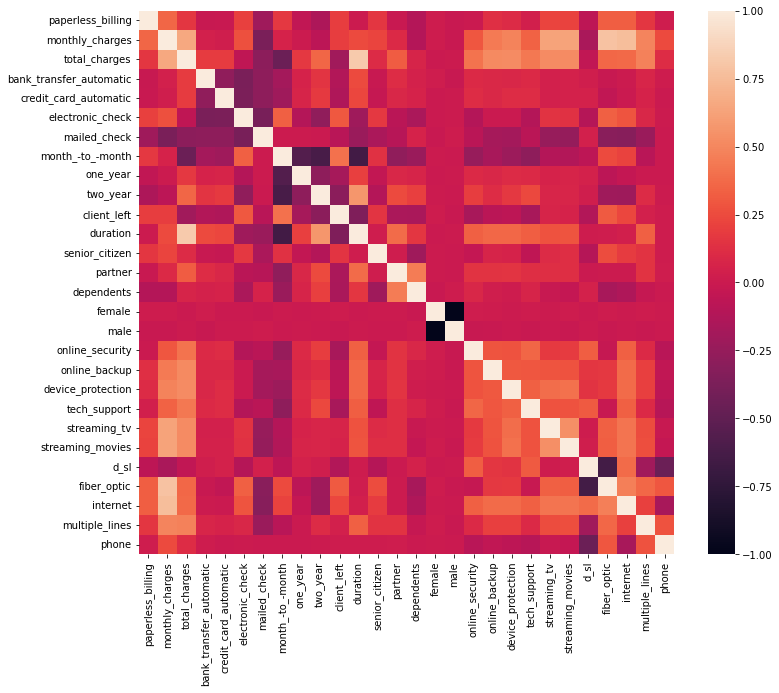

In [18]:
plt.subplots(figsize=(12, 10))
sns.heatmap(sum_data.corr())

### 2.2.7. Анализ некатегориальных данных в итоговом датасете
#### 2.2.7.1. total_charges

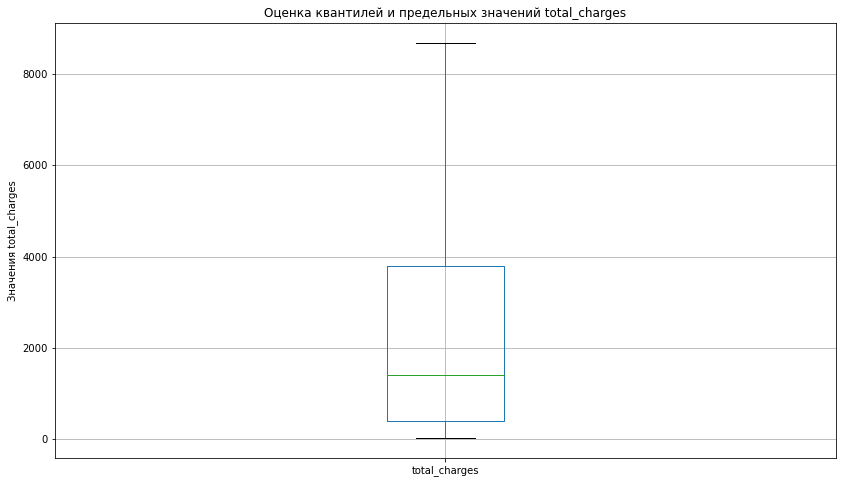

In [19]:
sum_data.boxplot(column='total_charges', figsize=(14, 8))
plt.title('Оценка квантилей и предельных значений total_charges')
plt.ylabel('Значения total_charges')
plt.show()

In [20]:
q3_temp, q1_temp, mn_temp, mx_temp = calc_quantiles(sum_data['total_charges'])
print(f'В основном значения total_charges находятся между квантилями в промежутке от {q1_temp} до {q3_temp} Значения выше {mx_temp} и ниже {mn_temp} можно расценивать как выбросы.')

В основном значения total_charges находятся между квантилями в промежутке от 401.45 до 3794.7375 Значения выше 8684.8 и ниже 18.8 можно расценивать как выбросы.


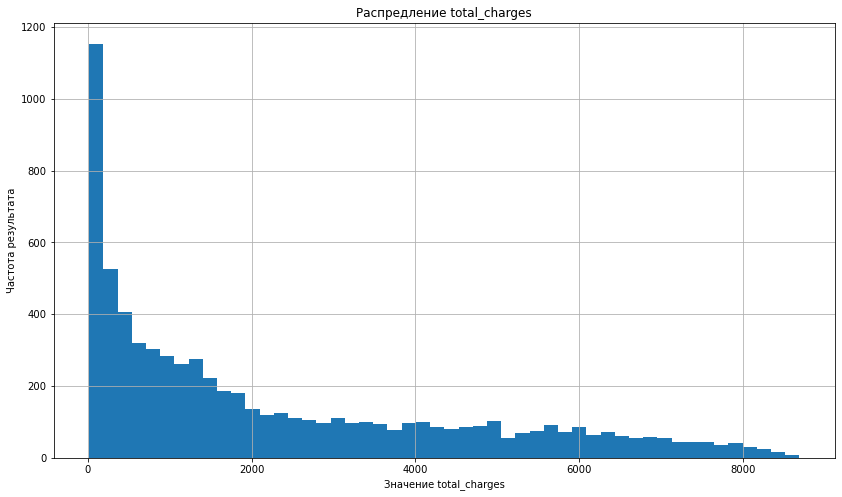

In [21]:
sum_data['total_charges'].hist(bins=50, figsize=(14, 8))
plt.title('Распредление total_charges')
plt.ylabel('Частота результата')
plt.xlabel('Значение total_charges')
plt.show()

#### 2.2.7.2. monthly_charges

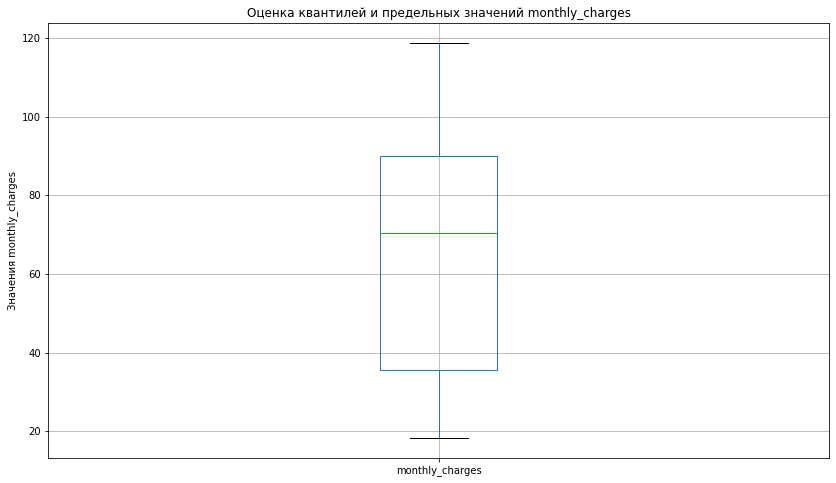

In [22]:
sum_data.boxplot(column='monthly_charges', figsize=(14, 8))
plt.title('Оценка квантилей и предельных значений monthly_charges')
plt.ylabel('Значения monthly_charges')
plt.show()

In [23]:
q3_temp, q1_temp, mn_temp, mx_temp = calc_quantiles(sum_data['monthly_charges'])
print(f'В основном значения monthly_charges находятся между квантилями в промежутке от {q1_temp} до {q3_temp} Значения выше {mx_temp} и ниже {mn_temp} можно расценивать как выбросы.')

В основном значения monthly_charges находятся между квантилями в промежутке от 35.5875 до 89.8625 Значения выше 118.75 и ниже 18.25 можно расценивать как выбросы.


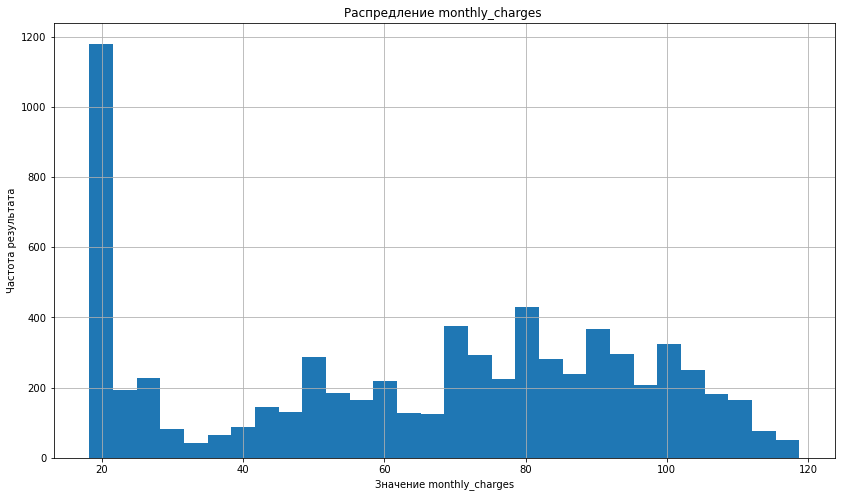

In [24]:
sum_data['monthly_charges'].hist(bins=30, figsize=(14, 8))
plt.title('Распредление monthly_charges ')
plt.ylabel('Частота результата')
plt.xlabel('Значение monthly_charges')
plt.show()

# 3. Формирование обучающей и тестовой выборок

In [25]:
# сначала разберемся с балансом классов
client_left = sum_data['client_left'].mean()
print(f'Доля ушедших клиентов: {np.round(client_left*100, 2)}%')

Доля ушедших клиентов: 26.58%


In [26]:
# формируем выборки
features = sum_data.drop(['client_left'], axis=1)
target = sum_data['client_left']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print('Размер features_train:', features_train.shape)
print('Размер target_train:', target_train.shape)
print('Размер features_test:', features_test.shape)
print('Размер target_test:', target_test.shape)

Размер features_train: (5625, 27)
Размер target_train: (5625,)
Размер features_test: (1407, 27)
Размер target_test: (1407,)


In [27]:
# Увеличим количество положительных случаев
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled 

In [28]:
features_train, target_train = upsample(features_train, target_train, 2)
print('Положительных ответов:', target_train.sum(), 'из', target_train.shape[0])
print('Доля положительных ответов:', target_train.sum() / target_train.shape[0])

Положительных ответов: 2978 из 7114
Доля положительных ответов: 0.4186111892043857


# 4. Выбор модели классификации

## 4.1. Предварительная оценка

In [29]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_train, target_train)

LogisticRegression(random_state=250722, solver='liblinear')

In [30]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

In [31]:
auc_roc = roc_auc_score(target_test, probabilities_one_test) 
print(auc_roc)

0.842000204991544


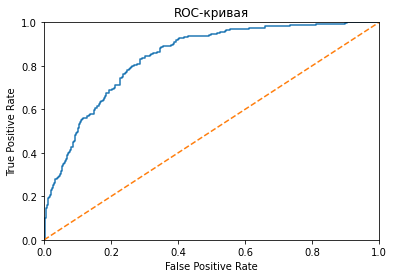

In [32]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()

# < постройте график >
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

In [33]:
for threshold in np.arange(0, 1, 0.02):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.270, Полнота = 1.000
Порог = 0.02 | Точность = 0.292, Полнота = 0.995
Порог = 0.04 | Точность = 0.312, Полнота = 0.989
Порог = 0.06 | Точность = 0.328, Полнота = 0.987
Порог = 0.08 | Точность = 0.340, Полнота = 0.984
Порог = 0.10 | Точность = 0.351, Полнота = 0.982
Порог = 0.12 | Точность = 0.361, Полнота = 0.976
Порог = 0.14 | Точность = 0.375, Полнота = 0.971
Порог = 0.16 | Точность = 0.388, Полнота = 0.968
Порог = 0.18 | Точность = 0.397, Полнота = 0.958
Порог = 0.20 | Точность = 0.405, Полнота = 0.950
Порог = 0.22 | Точность = 0.417, Полнота = 0.939
Порог = 0.24 | Точность = 0.438, Полнота = 0.937
Порог = 0.26 | Точность = 0.451, Полнота = 0.932
Порог = 0.28 | Точность = 0.461, Полнота = 0.921
Порог = 0.30 | Точность = 0.465, Полнота = 0.895
Порог = 0.32 | Точность = 0.481, Полнота = 0.887
Порог = 0.34 | Точность = 0.493, Полнота = 0.858
Порог = 0.36 | Точность = 0.505, Полнота = 0.847
Порог = 0.38 | Точность = 0.512, Полнота = 0.834
Порог = 0.40 | Точно

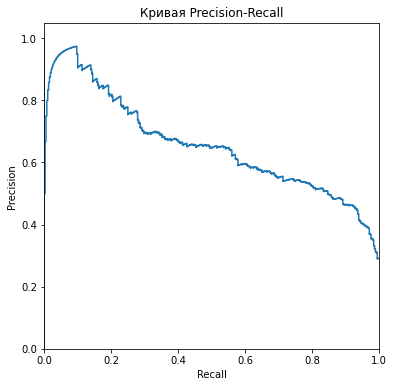

In [34]:
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one_test)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

## 4.2. Прогон нескольких моделей

In [35]:
models = [DummyClassifier(strategy='prior', random_state=RANDOM_STATE),
          LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
          DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=8), 
          RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200, max_depth=10),
          CatBoostClassifier(bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=200, learning_rate=0.03, silent=True, random_seed=RANDOM_STATE),
          LGBMClassifier(random_seed=RANDOM_STATE),
          XGBClassifier(random_seed=RANDOM_STATE),]

#          XGBRegressor(random_state=RANDOM_STATE, booster='gbtree', max_depth=4),
#          CatBoostRegressor(loss_function='RMSE', l2_leaf_reg=8, learning_rate=0.03, bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=500, silent=True, random_seed=RANDOM_STATE),
#          LGBMRegressor(boosting_type='gbdt', n_jobs=4, class_weight=None, learning_rate=0.03, n_estimators=300, random_state=RANDOM_STATE)

results = []

for md in models: 
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.datetime.now() # Засекли время начала обучения
    md.fit(features_train, target_train)
    t2 = datetime.datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    t4 = t2 - t1 # Время обучения
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах

    cv_roc_auc = abs(np.round(cross_val_score(md, features_train, target_train, cv=3, scoring='roc_auc').mean(), 4))
    print(f'-- cредняя оценка качества модели {md.__class__.__name__} методом кросс-валидации по метрике ROC-AUC:', cv_roc_auc)

    results.append({'Модель': md.__class__.__name__, 
                    'cv_roc_auc': cv_roc_auc,
                    'Гиперпараметры': md.get_params(deep=False),
                    'md': md,
                    'Время_обучения': dt1,                    
                    'Модель_пригодна': cv_roc_auc > CRIT_AUR_ROC}) 

    print('')

Идут вычисления по модели DummyClassifier: {'constant': None, 'random_state': 250722, 'strategy': 'prior'}
-- модель обучена
-- cредняя оценка качества модели DummyClassifier методом кросс-валидации по метрике ROC-AUC: 0.5

Идут вычисления по модели LogisticRegression: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 250722, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-- модель обучена
-- cредняя оценка качества модели LogisticRegression методом кросс-валидации по метрике ROC-AUC: 0.8468

Идут вычисления по модели DecisionTreeClassifier: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_stat

In [36]:
results = pd.DataFrame(results)
display(results.drop('md', axis=1))

,Модель,cv_roc_auc,Гиперпараметры,Время_обучения,Модель_пригодна
0,DummyClassifier,0.5000,"{'constant': None, 'random_state': 250722, 'st...",0.0s,False
1,LogisticRegression,0.8468,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.03s,True
2,DecisionTreeClassifier,0.8601,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.03s,True
3,RandomForestClassifier,0.9043,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.19s,True
4,CatBoostClassifier,0.9002,"{'iterations': 200, 'learning_rate': 0.03, 'de...",1.56s,True
5,LGBMClassifier,0.9310,"{'boosting_type': 'gbdt', 'class_weight': None...",0.12s,True
6,XGBClassifier,0.9461,"{'objective': 'binary:logistic', 'use_label_en...",0.41s,True


In [37]:
print('Лучшая модель:')
best = results.sort_values(by='cv_roc_auc', ascending=False).head(1).reset_index(drop=True)
display(best.drop('md', axis=1))

Лучшая модель:


,Модель,cv_roc_auc,Гиперпараметры,Время_обучения,Модель_пригодна
0,XGBClassifier,0.9461,"{'objective': 'binary:logistic', 'use_label_en...",0.41s,True


In [38]:
best_model = best.loc[0, 'md']
#pred = best_model.predict(features_test)
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test) 
print('ROC-AUC лучшей модели (на тестовой выборке):', np.round(auc_roc, 4))

ROC-AUC лучшей модели (на тестовой выборке): 0.9046


In [40]:
pred = best_model.predict(features_test)

vopr = pd.DataFrame()
vopr['target'] = target_test
vopr['predict'] = pred
vopr['proba'] = probabilities_one_test

In [41]:
display(vopr.head(20))

,target,predict,proba
6525,0,0,0.003697
108,0,0,0.234079
4822,0,0,0.007290
4951,0,1,0.789659
1361,1,1,0.973792
1525,0,0,0.014047
125,0,0,0.006702
4341,1,1,0.973317
3667,0,0,0.133551
1081,0,1,0.606830


## 4.3. Подбор гиперпараметров
1. Для подбора гиперпараметров использовалось следующее их множество:
* loss_function: ['RMSE', 'MAE']
* iterations: [200, 400, 500, 700]
* learning_rate: [0.03, 0.15]
* l2_leaf_reg: [3, 8]
* bootstrap_type: ['Bayesian', 'MVS']
* depth: [6, 10, 16]
* grow_policy: ['Lossguide']
* silent: True
* random_state: 250722

In [47]:
import xgboost as xgb
xgb.set_config(verbosity=0)
config = xgb.get_config()
assert config['verbosity'] == 0
# verbosity: Verbosity of printing messages. Valid values of 0 (silent), 1 (warning), 2 (info), and 3 (debug)

display(config)

{'use_rmm': False, 'verbosity': 0}

In [48]:
params = {'booster': ['gbtree', 'gblinear', 'dart'],
          'validate_parameters': [True, False]}

In [49]:
best_cv = 0
res_cv = []

for booster in params['booster']:
    for validate_parameters in params['validate_parameters']:
        md = XGBClassifier(booster=booster, validate_parameters=validate_parameters)
        print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
        md.fit(features_train, target_train)
        print('-- модель обучена')
        cv_roc_auc = abs(np.round(cross_val_score(md, features_train, target_train, cv=3, scoring='roc_auc').mean(), 4))
        print(f'-- cредняя оценка качества модели {md.__class__.__name__} методом кросс-валидации по метрике ROC-AUC:', cv_roc_auc)
        if cv_roc_auc > best_cv:
            best_cv = cv_roc_auc
            best_md = md
            
        res_cv.append({'cv_roc_auc': cv_roc_auc, 
                       'booster': booster,
                       'validate_parameters': validate_parameters}) 
                            
        print('')    

Идут вычисления по модели XGBClassifier: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': None, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': True, 'verbosity': None}
-- модель обучена
-- cредняя оценка качества модели XGBClassifier методом кросс-валидации по метрике ROC-AUC: 0.9461

Идут вычисления по модели XGBClassifier: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': None, 'booster': 'gbtree', 'cols

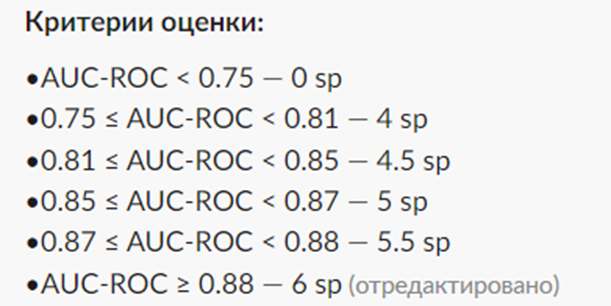

### Вывод:
1. Можно использовать переметры XGBClassifier по умолчанию.
2. Методы gbtree или dart дают одинаково хорошие результаты.
3. validate_parameters не влияет на качество модели.

In [50]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test) 
print('ROC-AUC лучшей модели (на тестовой выборке):', np.round(auc_roc, 4))

ROC-AUC лучшей модели (на тестовой выборке): 0.9046


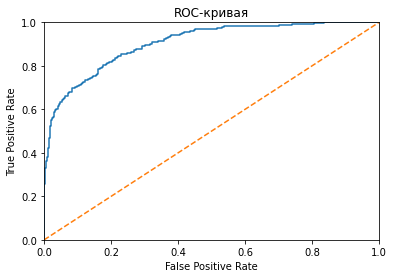

In [51]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()

# < постройте график >
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()